### Download the Automobile data set
<b>Download link:</b> https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('Predicting the price of an automobile given a set of features') \
    .getOrCreate()

rawData = spark.read\
            .format('csv')\
            .option('header', 'true')\
            .load('../datasets/imports-85.data')

In [2]:
rawData.toPandas().head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8,115,5500,18,22,17450


#### Select the required columns
* We can select the specific features we feel are relevant in our dataset
* fields such as normalized-losses have been dropped
* The numeric fields can be cast as float or any numeric type

In [3]:
from pyspark.sql.functions import col

dataset = rawData.select(col('price').cast('float'), 
                         col('make'), 
                         col('num-of-doors'), 
                         col('body-style'), 
                         col('drive-wheels'), 
                         col('wheel-base').cast('float'), 
                         col('curb-weight').cast('float'), 
                         col('num-of-cylinders'), 
                         col('engine-size').cast('float'), 
                         col('horsepower').cast('float'), 
                         col('peak-rpm').cast('float')
                        )

In [4]:
dataset.toPandas().head()

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,peak-rpm
0,13495.0,alfa-romero,two,convertible,rwd,88.599998,2548.0,four,130.0,111.0,5000.0
1,16500.0,alfa-romero,two,convertible,rwd,88.599998,2548.0,four,130.0,111.0,5000.0
2,16500.0,alfa-romero,two,hatchback,rwd,94.500000,2823.0,six,152.0,154.0,5000.0
3,13950.0,audi,four,sedan,fwd,99.800003,2337.0,four,109.0,102.0,5500.0
4,17450.0,audi,four,sedan,4wd,99.400002,2824.0,five,136.0,115.0,5500.0


#### Drop columns with nulls
Check number of rows in dataset before and after removal of nulls

In [5]:
dataset.count()

205

In [6]:
dataset = dataset.replace('?', None).dropna(how='any')

In [7]:
dataset.count()

197

#### Split dataset into training and test sets

In [8]:
(trainingData, testData) = dataset.randomSplit([0.8,0.2])

#### List the categorical fields so that we can transform these to encoded values

In [9]:
categoricalFeatures = ['make',
                       'num-of-doors',
                       'body-style',
                       'drive-wheels',
                       'num-of-cylinders'
                      ]                     

#### Import and implement the required transformers

In [10]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

#### Use of handleInvalid in StringIndexer
If the model comes across a new label which it hasn't seen in the training phase, it is deemed an "invalid" label. There are different ways of handling this:
* handleInvalid='skip' will remove rows with new labels
* handleInvalid='error' will cause an error when a new label is encountered
* handleInvalid='keep' will create a new index if it encounters a new label (available from Spark 2.2 onwards)

In [11]:
indexers = [StringIndexer(
    inputCol=column, 
    outputCol=column + '_index', 
    handleInvalid='keep') for column in categoricalFeatures]

#### One-Hot-Encode the features

In [12]:
encoders = [OneHotEncoder(
    inputCol=column + '_index', 
    outputCol= column + '_encoded') for column in categoricalFeatures]

#### List all the required features from the transformed dataset

In [13]:
requiredFeatures = ['make_encoded',
                    'num-of-doors_encoded',
                    'body-style_encoded',
                    'drive-wheels_encoded',
                    'wheel-base',
                    'curb-weight',
                    'num-of-cylinders_encoded',
                    'engine-size',
                    'horsepower',
                    'peak-rpm'
                   ]

#### Prepare the feature assembler

In [15]:
# Create a dense vector of our features
assembler = VectorAssembler(inputCols=requiredFeatures,
                                    outputCol='features')

#### Linear Regression



By setting α properly, elastic net contains both L1 and L2 regularization as special cases. 
* If the elasticNetParam α is set to 1, it is equivalent to a Lasso model
* If α is set to 0, the trained model reduces to a ridge regression model

regParam is the regularization variable

1. **`maxIter`**:  no of epochs we run where 1 epoch is 1 run through the entire dataset
2. **`regParam`**: is the regularization penalty / alpha that is applied to model coefficients
3. **`elasticNetParam`**: It helps to move between ridge and lasso. When set at 0, it becomes lasso regression and when set to 1.0 it becomes ridge. 0.8 tends more toward ridge than lasso

In [16]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=100,
                      regParam=1.0,
                      elasticNetParam=0.8,
                      labelCol='price', 
                      featuresCol='features')

#### Define our pipeline
It contains all our transformers plus the model

In [17]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

In [18]:
model = pipeline.fit(trainingData)
model

PipelineModel_c9eb39125d3f

### Extract the model from the pipeline
* Our LinearRegression model is not the same as the pipeline model
* To extract the LinearRegression model, we get it from the last stage of our pipeline model

In [19]:
model.stages

[StringIndexer_2bfd04b6d9c7,
 StringIndexer_1509fa20c2c4,
 StringIndexer_bbff369acf26,
 StringIndexer_7a00ca63a08f,
 StringIndexer_51fc28cf608d,
 OneHotEncoder_6d57e1a18ffa,
 OneHotEncoder_9b7aecb3ff69,
 OneHotEncoder_82911f82853e,
 OneHotEncoder_485a2363f6b0,
 OneHotEncoder_616a4abf98ab,
 VectorAssembler_4ca11a620428,
 LinearRegression_079b0b74b18a]

In [20]:
lrModel = model.stages[-1]

In [21]:
# How did model perform with training data 
print('Training RMSE = ', lrModel.summary.rootMeanSquaredError)
print('Training R^2 score = ', lrModel.summary.r2)

Training RMSE =  1819.1982770234183
Training R^2 score =  0.9447628022971201


#### Check the number of features
The number will be high as many of our features are one-hot-encoded

In [22]:
lrModel.numFeatures

42

#### View the coefficients of each feature

In [23]:
lrModel.coefficients

DenseVector([-2071.7014, -1003.9763, 64.6632, -1856.4063, -1255.9619, -478.358, -2241.721, -1722.5652, 465.4601, -1499.2717, 7480.8229, 2406.6312, 8145.7115, 904.7486, -1765.0501, 12094.002, -515.4822, -919.2158, -2005.3556, 3555.8887, -14.8077, 14.8077, 407.91, -66.492, -921.4491, 505.1926, 4117.9688, 327.9223, -77.4295, 84.1881, 142.249, 4.5279, -1063.6532, 1116.1336, -332.82, 3407.681, 1956.8465, 1534.3907, 3555.8887, 6.4346, 44.3432, 0.0])

#### There is a coefficient for each feature

In [24]:
len(lrModel.coefficients)

42

#### Get predictions using our model on the test data

In [25]:
predictions = model.transform(testData)
predictionsDF = predictions.toPandas()
predictionsDF.head(4)

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,...,body-style_index,drive-wheels_index,num-of-cylinders_index,make_encoded,num-of-doors_encoded,body-style_encoded,drive-wheels_encoded,num-of-cylinders_encoded,features,prediction
0,5195.0,mazda,two,hatchback,fwd,93.099998,1890.0,four,91.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7096.060154
1,5389.0,mitsubishi,two,hatchback,fwd,93.699997,1918.0,four,92.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",5008.241270
2,5572.0,dodge,two,hatchback,fwd,93.699997,1876.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5547.649116
3,5572.0,plymouth,two,hatchback,fwd,93.699997,1918.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5472.042991


#### The features have been transformed to LibSVM format

In [26]:
predictionsDF['features'][0]

SparseVector(42, {2: 1.0, 21: 1.0, 23: 1.0, 27: 1.0, 30: 93.1, 31: 1890.0, 32: 1.0, 39: 91.0, 40: 68.0, 41: 5000.0})

We see the dense vector has 42 features after OHE, that has been fed to the model.

### Use RegressionEvaluator to evaluate the model
* MulticlassClassificationEvaluator is used for classification models
* RegressionEvaluator needed to evaluate regression models
* <b>metricName </b>can be r2, rmse, mse or mae (mean absolute error)

In [27]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='r2')

r2 = evaluator.evaluate(predictions)
print('Test R^2 score = ', r2)

Test R^2 score =  0.9333442413146377


In [28]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = evaluator.evaluate(predictions)
print('Test RMSE = ', rmse)

Test RMSE =  2291.4847952307523


#### Compare the actual and predicted values of price

In [29]:
predictionsPandasDF = predictions.select(
    col('price'),
    col('prediction')
).toPandas()

In [30]:
predictionsPandasDF.head()

,price,prediction
0,5195.0,7096.060154
1,5389.0,5008.241270
2,5572.0,5547.649116
3,5572.0,5472.042991
4,6575.0,6924.398657


#### Plot a graph of actual and predicted values of price
Note that our predictions dataset is sorted in ascending order of price

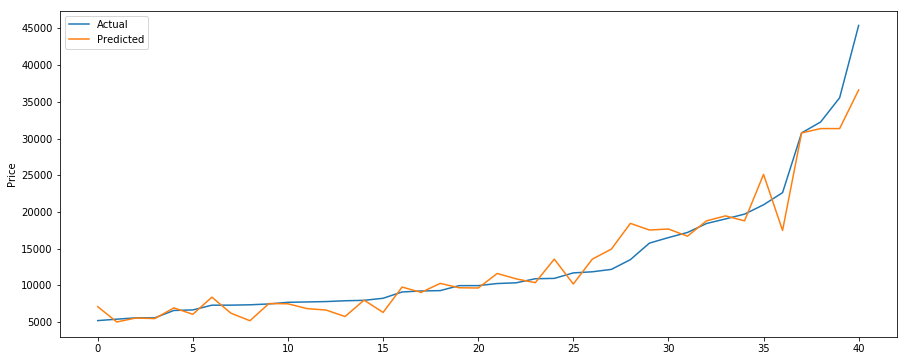

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

plt.plot(predictionsPandasDF['price'], label='Actual')
plt.plot(predictionsPandasDF['prediction'], label='Predicted')

plt.ylabel('Price')
plt.legend()

plt.show();

### Using ParamGrid for hyperparameter tuning
The parameters we wish to tweak are:

1. **`maxIter`**:  no of epochs we run, where 1 epoch is 1 run through the entire dataset
2. **`regParam`**: is the regularization penalty / alpha that is applied to model coefficients
3. **`elasticNetParam`**: It helps to move between ridge and lasso. When set at 0, it becomes lasso regression and when set to 1.0 it becomes ridge. 0.8 tends more toward ridge than lasso

In [33]:
# ParamGridBuilder required for hyperparameter tuning
from pyspark.ml.tuning import ParamGridBuilder

# lr is the linear regression object
paramGrid = ParamGridBuilder().addGrid(
    lr.maxIter, [10,50,100]).addGrid(
    lr.regParam, [0.1, 0.3, 1.0]).addGrid(
    lr.elasticNetParam, [0.0, 1.0]).build()

#### Define the RegressionEvaluator used to evaluate the models
We wish to minimize RMSE

In [34]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='rmse')

### Define the CrossValidator
This is used to put all the pieces together
* <b>estimator: </b>Can be a standalone estimator or a pipeline with an estimator at the end. We use our pipeline
* <b>estimatorParamMaps: </b>We add our paramGrid in order to build models with different combinations of the parameters
* <b>evaluator: </b>To evaluate each model, we specify our evaluator

In [35]:
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

#### Train each of our models with the training data
After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset

In [36]:
model = crossval.fit(trainingData)

#### To examine our best model, we extract it from the pipeline

In [37]:
lrModel = model.bestModel.stages[-1]
lrModel

LinearRegression_079b0b74b18a

#### Get the values of the "best" parameters
Unfortunately, extracting these values is a bit awkward as we need to access the \_java\_obj object 

In [38]:
print('maxIter=', lrModel._java_obj.getMaxIter())
print('elasticNetParam=', lrModel._java_obj.getElasticNetParam())
print('regParam=', lrModel._java_obj.getRegParam())

maxIter= 10
elasticNetParam= 1.0
regParam= 0.1


Best model we got is **ridge regularization model** (elasticNetParam= 1.0 means ridge, 0 means lasso), with a regularization **penalty value of 0.1** and **10 epochs**.

#### Make predictions using our "best" model

***model contains the best model from cross-validation***

In [41]:
predictions = model.transform(testData)
predictionsDF = predictions.toPandas()
predictionsDF.head(4)

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,...,body-style_index,drive-wheels_index,num-of-cylinders_index,make_encoded,num-of-doors_encoded,body-style_encoded,drive-wheels_encoded,num-of-cylinders_encoded,features,prediction
0,5195.0,mazda,two,hatchback,fwd,93.099998,1890.0,four,91.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6986.389344
1,5389.0,mitsubishi,two,hatchback,fwd,93.699997,1918.0,four,92.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",5134.809499
2,5572.0,dodge,two,hatchback,fwd,93.699997,1876.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5409.045108
3,5572.0,plymouth,two,hatchback,fwd,93.699997,1918.0,four,90.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5009.971051


#### Evaluate the model on it's R-square score and RMSE

In [42]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='r2')

rsquare = evaluator.evaluate(predictions)
print("Test R^2 score = %g" % rsquare)

Test R^2 score = 0.936359


In [44]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = evaluator.evaluate(predictions)
print('Test RMSE = ', rmse)

Test RMSE =  2239.0679383549495


#### Compare actual and predicted values of price

In [45]:
predictionsPandasDF = predictions.select(
    col('price'),
    col('prediction')).toPandas()

predictionsPandasDF.head()

,price,prediction
0,5195.0,6986.389344
1,5389.0,5134.809499
2,5572.0,5409.045108
3,5572.0,5009.971051
4,6575.0,7311.494198


#### Perform the comparison using a graph

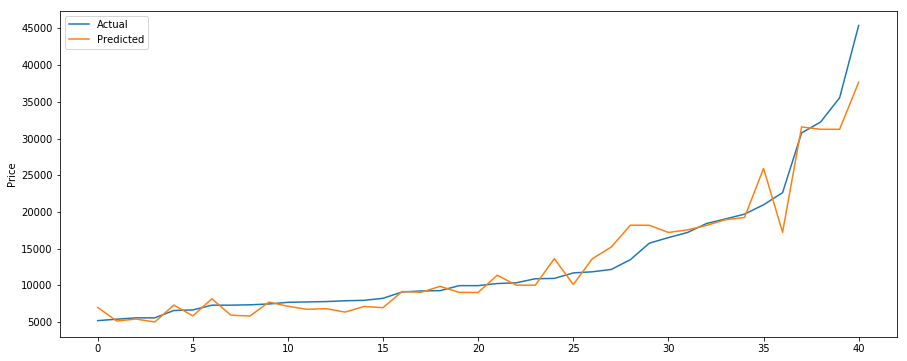

In [46]:
plt.figure(figsize=(15,6))

plt.plot(predictionsPandasDF['price'], label='Actual')
plt.plot(predictionsPandasDF['prediction'], label='Predicted')

plt.ylabel('Price')
plt.legend()

plt.show()